## MIE 1624 - Introduction to Data Science and Analytics -Fall 2017
### Assignment 1
#Cheng Zhou 
#Student Number: 998283263
#Due Nov 13, 2017

### Import packages

In [1]:
import numpy as np
import pandas as pd
import string
import re
import html.parser    
import operator
from os import path

from collections import Counter
import re
import codecs
counter = Counter()

#Import feature extraction functions (bag of words and unigram)
from __future__ import division, print_function, absolute_import
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LogisticRegression   

# import machine learning modules
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, accuracy_score

from sklearn.model_selection import train_test_split
from sklearn.cross_validation import train_test_split
from sklearn.model_selection import learning_curve
from sklearn.learning_curve import learning_curve
#Import plot 
import matplotlib.pyplot as plt
#from wordcloud import WordCloud




/Users/zhouc6/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/zhouc6/anaconda3/lib/python3.6/site-packages/sklearn/learning_curve.py:22: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  DeprecationWarning)


In [2]:
#save stopwords in a list
stopwords = []
with open('stop_words.txt') as stopword:
    stopwords = stopword.read().lower().split()

# 1. Data Cleaning
Clean the twitter data by qualifying the following requirements
o All html tags and attributes (i.e., /<[^>]+>/) are removed.
o Html character codes (i.e., &...;) are replaced with an ASCII equivalent.
o All URLs are removed.
o All characters in the text are in lowercase.
o All stopwords are removed. Be clear in what you consider as a stopword.
o If a tweet is empty after pre-processing, it should be preserved as such.

In [3]:
def clean_data(tw):

    #All HTML characted code replaced with ASC2 equivalent
    tw = html.unescape(tw)
    #All URLs are removed
    tw = re.sub(r"http\S+", "",tw)
    tw = re.sub(r"pic.twitter.com\S+", "",tw) 
    tw = re.sub(r"twitter.com\S+", "",tw) 
    #All html tags are removed,user tags, hashtags are kept
    tw = re.sub(r'[^\@\#\w\s]',' ',tw) 
    #All characters in lowercase
    tw = str(tw).lower()
    return ' '.join(word.lower() for word in tw.split() if word.lower() not in stopwords)

In [4]:
#Tweets in the classified_tweets.txt file are formed into pandas Dataframe with each comma-seperated field
tweet = pd.read_csv("classified_tweets.txt", sep=',', names=['senti','id','date','query','user','text'],error_bad_lines=False, index_col=False, dtype='unicode')
tweet = pd.DataFrame(tweet[1:])
tweet = tweet.reset_index(drop=True)
tweet.senti =tweet.senti.apply(str)
tweet.text= tweet.text.apply(str) 
tweet.head()

,senti,id,date,query,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [5]:
#Clean the tweets data in classified.text for analysis
clean_tweet = []
for line in tweet.text:
    clean_tweet.append(clean_data(line))
tweet.drop('text', axis=1, inplace=True)
tweet['text'] = clean_tweet
#Remove inrrelevant columns
columns = ['id','date','query','user']
tweet.drop(columns, axis=1, inplace=True)
tweet.head()

,senti,text
0,0,@switchfoot awww bummer shoulda david carr thi...
1,0,upset update facebook texting cry result schoo...
2,0,@kenichan dived times ball managed save 50 res...
3,0,body feels itchy fire
4,0,@nationwideclass behaving mad


In [6]:
#Tweets in the unclassified_tweets.txt file are formed into pandas Dataframe 
elct_tweet = pd.read_csv("unclassified_tweets.txt", sep=',', names=['text'],error_bad_lines=False, index_col=False, dtype='unicode')
elct_tweet = pd.DataFrame(elct_tweet[0:])
elct_tweet = elct_tweet.reset_index(drop=True)
elct_tweet.text= elct_tweet.text.apply(str) 
elct_tweet.head()

,text
0,living the dream. #cameraman #camera #camerace...
1,justin #trudeau's reasons for thanksgiving. to...
2,@themadape butt…..butt…..we’re allergic to l...
3,2 massive explosions at peace march in #turkey...
4,#mulcair suggests there’s bad blood between hi...


In [7]:
#Clean the tweets data in unclassified.txt for analysis
clean_elct_tweet = []
for line in elct_tweet.text:
    clean_elct_tweet.append(clean_data(line))
elct_tweet.drop('text', axis=1, inplace=True)

elct_tweet['text']= clean_elct_tweet
elct_tweet.head(10)

,text
0,living dream #cameraman #camera #cameraception...
1,justin #trudeau reasons thanksgiving today mon...
2,@themadape butt butt allergic latex sneeze #nb...
3,2 massive explosions peace march #turkey 30 ki...
4,#mulcair suggests bad blood #trudeau worldwide...
5,#polqc se sort de la marde avec #harper prêt à...
6,harper 8m help countries wing govt elected boi...
7,tommy taylor
8,@justintrudeau @thomasmulcair
9,tracy retweeted tsec


# 2. Exploratory analysis 


## 2(a) 
Design a simple procedure that determines the political party of a given tweet

In [8]:
# Categorize Tweets
'''
    **Procedure to categorize the political affiliation a tweet**
    
    1.Firstly, a list of informative words for each party is created ,while a certain word in
    the tweet appears after hashtags and at signs matches with the word in one party list,
    this word is considered as a word shows affiliation of that particular party
    
    2. Substract the hashtags and at signs of each tweet and check 
    if hashtags and the words after at signs match with defined categories that contains 
    certain hashtags and twitter users, count the number of hastags and at signs in each
    category.
    
    2.If there is no political hashtags in the tweet, it is assumed there is no
    affiliation to a particular party. It assigns to 'Others'.
    
    3. If there are two or more party categories in a single tweet, and they 
    have same  number of hashtags, the tweet is still assigned to 'Others' because 
    its political affiliation is not clear.
    
    4. The tweet with a dominant number of hastags in a specific party category is 
    assigned to that particular party.
    
'''
# create a list to save hashtag words
hashtags = []
lib = 0 # initial value of each category is 0
con = 0
ndp = 0
others = 0
#Political Parties categorized into Liberals, Conservatives and New Development
party = dict(Liberal=lib, Conservative=con,NDP=ndp)

#Key words are chosen based on the political affiliation showned in the hashtags
liberal = ['lpc','liberal','trudeau','ptlib','ignatieff','lpcldr','justintrudeau','liberal_party',\
                 'trudeaus']
conservative = ['cpc','conservative','stephen','harper','stephenharper'\
                      'pttory','clsh','robocall']
NDP = ['ndp','newdemocratic','ndpapc','mulcair','tommulcair',\
             'ptndp','ndpldr','laytondp8']
elct_tweet.text= [re.sub(r'[\@]',' @',line) for line in elct_tweet.text]
elct_tweet.text= [re.sub(r'[\#]',' #',line) for line in elct_tweet.text]



In [9]:
def party(tw):
    #hashtags_list = []
    hashtags = []
    lib = 0 # initial value of each category is 0
    con = 0
    ndp = 0
        # define categories of hashtags
    liberal = ['lpc','liberal','trudeau','ptlib','ignatieff','lpcldr','justintrudeau','liberal_party',\
                     'trudeaus']
    conservative = ['cpc','conservative','stephen','harper','stephenharper'\
                          'pttory','clsh','robocall']
    NDP = ['ndp','newdemocratic','ndpapc','mulcair','tommulcair',\
                 'ptndp','ndpldr','laytondp8']
    tw= re.sub(r'[\@]',' @',tw) 
    tw= re.sub(r'[\#]',' #',tw) 
    party = dict(Liberal=lib, Conservative=con,NDP=ndp)
    
    #print(tw)
    word = tw.split()
    #print(item)
    for a in word:
        if '#' in a:
                # delete hashtag sign
            a = a.replace('#','') 
            hashtags.append(a)
        elif '@' in word:
                #delete @ sign
            a = a.replace('@','') 
            hashtags.append(a)
    #print(hashtags)
        #count the number of keywords of affliation of political parties appeared in each tweet
    for i in hashtags:
        if i in liberal:
            lib = lib + 1
        elif i in conservative:
            con = con + 1
        elif i in NDP:
            ndp = ndp +1
    #print(lib)
    #print(con)
    #print(ndp)
    score = [lib,con,ndp]
    party = dict(Liberal=lib, Conservative=con,NDP=ndp)
    maximum = max(party.values())
    #print(maximum)
    if (maximum == 0): 
        #print("['Others']")
        keys ="Others"
        #print(keys)
    elif (lib==maximum and con ==maximum) or (lib == maximum and ndp==maximum) or (con ==maximum and ndp ==maximum):
        #print("['Others']")
        keys = "Others"
        #print(keys)
    else:
        for key, value in party.items():
            if value == maximum:
                keys = key
        #keys = [key for key, value in party.items() if value == maximum]
    #print(keys)
    return keys

    
  

In [10]:
#This shows the result of the political affiliation of each tweet
party_affl = []
for line in elct_tweet.text:
    #line = clean_data(line)
    elct_party = party(line)
    party_affl.append(elct_party)
    
#Add party column to the dataframe
elct_tweet['party']= party_affl
elct_tweet.head()


,text,party
0,living dream #cameraman #camera #cameracept...,NDP
1,justin #trudeau reasons thanksgiving today mo...,Liberal
2,@themadape butt butt allergic latex sneeze #...,Others
3,2 massive explosions peace march #turkey 30 k...,Others
4,#mulcair suggests bad blood #trudeau worldwi...,NDP


## 2(b)
Present a graphical figure (e.g. chart, graph, histogram, boxplot, word cloud, etc) that
visualizes some aspect of the unclassified data and another figure for the classified
data. All graphs and plots should be readable and have all axes that are appropriately
labelled.

Conservative    316.0
Liberal         362.0
NDP             257.0
dtype: float64
Partys Mentioned in Twitter hashtags


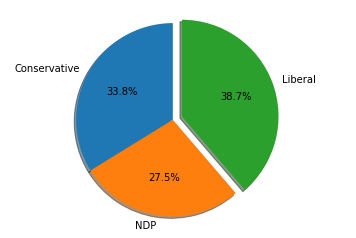

In [11]:
#Count the total number of tweets that attend to support each party
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
party_cnt = elct_tweet.party.apply(lambda x: pd.value_counts(str(x).split(" "))).sum(axis = 0)
total = sum(party_cnt) - party_cnt.Others

#A pie chart that shows the proportion of each party that were mentioned in the tweet hashtags
labels = 'Conservative','NDP','Liberal'
fracs = [(party_cnt.Conservative/total)*100,\
          (party_cnt.NDP/total)*100,(party_cnt.Liberal/total)*100,]

explode = (0, 0, 0.1)  # only "explode" the 2nd slice (i.e. 'Liberal')
# Make square figures and axes
fig1, ax1 = plt.subplots()
ax1.pie(fracs, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
print(party_cnt[:3])
print('Partys Mentioned in Twitter hashtags')
plt.show()

### “What can public opinion on Twitter tell us about the Canadian political landscape in 2015?”
Liberal Party leads the number of tweets related to them and number of positive
sentiment tweets followed by Conservative and New Development, which implies Liberal Party has the largest Canadian political landscape,Conservative is the second largest and New Democratic holds the third place, which is consistent to the actual situation. ( e.g Liberal:39.47%	Conservative:31.89%	 New Democratic:19.71%)

[('work', 6477), ('day', 5838), ('today', 5019), ('going', 4381), ('don', 3937), ('good', 3760), ('time', 3614), ('sad', 3231), ('2', 3021), ('sleep', 2913), ('night', 2841), ('will', 2763), ('tomorrow', 2721), ('lol', 2663), ('bad', 2565), ('feel', 2558), ('well', 2454), ('school', 2257), ('morning', 2235), ('hate', 2113)]
[('good', 11799), ('day', 11365), ('work', 8953), ('today', 8882), ('going', 8475), ('love', 7634), ('time', 7504), ('lol', 6809), ('will', 6429), ('don', 6176), ('night', 6057), ('well', 5426), ('morning', 5203), ('2', 5194), ('ll', 4833), ('twitter', 4821), ('great', 4491), ('tomorrow', 4456), ('sleep', 4318), ('hope', 4252)]


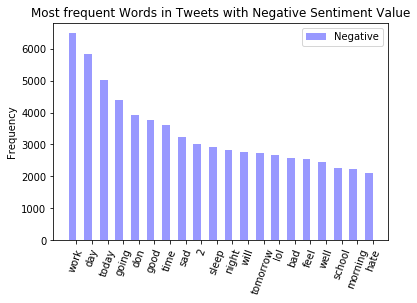

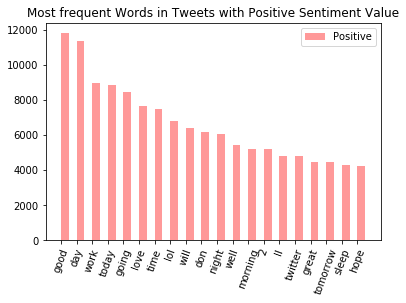

In [12]:
#This part show bar charts for most frequently used words in classified data grouped by sentiment value
from collections import Counter
import re
import codecs
counter = Counter()
for i in range(len(tweet)//2):
    counter.update([word for word in re.findall(r'\w+', tweet['text'][i])])

neg_words =counter.most_common(20)
print(neg_words)
for i in range(len(tweet)//2,len(tweet)):
    counter.update([word for word in re.findall(r'\w+', tweet['text'][i])])

pos_words =counter.most_common(20)
print(pos_words)
x1_labels = list(zip(*neg_words))[0]
y1_labels = list(zip(*neg_words))[1]
x2_labels = list(zip(*pos_words))[0]
y2_labels = list(zip(*pos_words))[1]
x_labels = list(set(x1_labels+x2_labels))      
x_pos = np.arange(len(x1_labels)) 
fig, ax = plt.subplots()

bar_width = 0.5

opacity = 0.4
error_config = {'ecolor': '0.3'}
plt.bar(x_pos, y1_labels, bar_width,
                 alpha=opacity,
                 color='b',
                 error_kw=error_config,
                 label='Negative')
 
plt.ylabel('Frequency')
plt.title('Most frequent Words in Tweets with Negative Sentiment Value')
plt.xticks(x_pos + bar_width / 2, x1_labels)
plt.xticks(rotation=70)
plt.legend()
plt.show()

plt.title('Most frequent Words in Tweets with Positive Sentiment Value')
plt.bar(x_pos + bar_width, y2_labels, bar_width,
                 alpha=opacity,
                 color='r',
                 error_kw=error_config,
                 label='Positive')

plt.xticks(x_pos + bar_width / 2, x2_labels)
plt.xticks(rotation=70)
plt.legend()
plt.show()

# 3. Model Preparation
Split the classified data randomly into training data (70%) and test data (30%). Prepare
the data for logistic regression where each tweet is considered a single observation. 
In the logistic regression model, the outcome variable is the sentiment value, which is either
positive or negative. 
The independent variables or features of the model can be whateverou want. 
As a suggestion, you can use the frequency of each word as the features of the
model, or alternatively, you can first tag each n-gram by its part of speech and then use
the frequency of each part of speech as the features of the model.

In [15]:
len(tweet)
dataset_x = tweet['text']
dataset_y = tweet['senti']
tweet.loc[tweet['senti'] == '0', 'senti'] = 0
tweet.loc[tweet['senti'] == '4', 'senti'] = 1
#Split the data randomly into training data (70%) and test data (30%)
x_train, x_test, y_train, y_test = train_test_split(dataset_x, dataset_y, test_size = 0.3)
#Output variables are sentiment values
y_train = y_train.astype('int')
#Use the frquency of words appeared in each tweet as features for model training
bag_of_words = CountVectorizer(None, ngram_range=(1, 2),max_df =0.75)
x_train_BOW = bag_of_words.fit_transform(x_train)
tweet['BOW'] = x_train_BOW
x_test_BOW = bag_of_words.transform(x_test)
tweet.head()

,senti,text,BOW
0,0,@switchfoot awww bummer shoulda david carr thi...,"(0, 350521)\t1\n (0, 447693)\t1\n (0, 3505..."
1,0,upset update facebook texting cry result schoo...,"(0, 350521)\t1\n (0, 447693)\t1\n (0, 3505..."
2,0,@kenichan dived times ball managed save 50 res...,"(0, 350521)\t1\n (0, 447693)\t1\n (0, 3505..."
3,0,body feels itchy fire,"(0, 350521)\t1\n (0, 447693)\t1\n (0, 3505..."
4,0,@nationwideclass behaving mad,"(0, 350521)\t1\n (0, 447693)\t1\n (0, 3505..."


# 4.Model Implementation
Train a logistic regression model on the training data and apply the model to the test data
to obtain an accuracy value. Evaluate the same model with the unclassified data.

In [16]:
#Train a logistic regression modeling using the data defined 
model = LogisticRegression()
model.fit(x_train_BOW, y_train)
label_predicted = model.predict(x_test_BOW)
label_actual = np.array(y_test)
correct_counter = 0

for i in range(0, len(label_predicted)):
    if label_predicted[i] == label_actual[i]:
        correct_counter = correct_counter + 1
#Obtain the accuracy value of the training data
accuracy = correct_counter/len(label_predicted)
print("\nThe accuracy for classified trainning is",accuracy)


The accuracy for classified trainning is 0.7508166666666667


In [17]:
#Here we want to predict the sentiment value of each unclassfied tweet
senti_elct= []
dataset_x = tweet['text']
dataset_y = tweet['senti']
tweet.loc[tweet['senti'] == '0', 'senti'] = 0
tweet.loc[tweet['senti'] == '4', 'senti'] = 1
#Split the classified data randomly into training data (70%) and test data (30%)
x_train, x_test, y_train, y_test = train_test_split(dataset_x, dataset_y, test_size = 0.3)
#Output variable are sentiment values
y_train = y_train.astype('int')
# To automatically detect and filter stop words based on intra corpus document frequency of terms.
bag_of_words = CountVectorizer(None, ngram_range=(1, 2),max_df =0.75 )
x_train_BOW = bag_of_words.fit_transform(x_train)
x_test_BOW = bag_of_words.transform(x_test)

#Evaluate the model with unclassfied data
model = LogisticRegression()
model.fit(x_train_BOW, y_train)
x_un_train_BOW = bag_of_words.transform(elct_tweet.text)
#Predicted sentiment values of unclassfied tweets
senti_elct = model.predict(bag_of_words.transform(elct_tweet.text))    
elct_tweet['senti']=senti_elct

In [18]:
elct_tweet.head()

,text,party,senti
0,living dream #cameraman #camera #cameracept...,NDP,0
1,justin #trudeau reasons thanksgiving today mo...,Liberal,1
2,@themadape butt butt allergic latex sneeze #...,Others,0
3,2 massive explosions peace march #turkey 30 k...,Others,1
4,#mulcair suggests bad blood #trudeau worldwi...,NDP,0


In [19]:
result = pd.DataFrame(elct_tweet.groupby('party').senti.value_counts())
result.columns = ['count']
print('Statistics on Tweet Sentiments for 2015 Canadian Federal Election')
result.head(6)

Statistics on Tweet Sentiments for 2015 Canadian Federal Election


count
party        senti       
Conservative 1        183
             0        133
Liberal      1        250
             0        112
NDP          1        201
             0         56

# 5. Discussion
Answer the research question stated above. Describe the results of the analysis and
discuss your interpretation of the results. Did you gain any potential insights into the
political sentiment of the Canadian electorate with respect to the major political parties
participating in the 2015 federal election? Explain how each political party is viewed in
the public eye based on the sentiment value.

### Describe the results of the analysis and discuss your interpretation of the results.
Classified Tweets:
The frequency of unigram in the tweets have been counted as features for logistic regression model training. For 1 trial no fold, the accuracy on classifying sentiment values of Canadian Federal election tweets based on 7:3 training and testing dataset split of 200,000 tweets is about 75%, therefore is model is considered reliable. The accuracy
could be further improved by more accurate feature selection (e.g. changing hyper parameter).

Unclassified Tweets:
Based on the predictions of all the unclassified tweets using the training model, Liberal party has the highest  number of positive tweets (250) as well as the highest number of mentions in the hashtags (362) related
to their political topics, while Conservative and Ndp have 183 and 201 positive tweets, respectively. This implies that Liberal Party is the most trending political Party based on the number of mentions and hashtags. At the same time it is the most popular Party compared to other Parties in the 2015 Canadian Federal Election based on the number of tweets of positive sentiment.

Liberal Party leads the number of tweets related to them and number of positive sentiment tweets followed by Conservative and New Development, which implies Liberal Party has the largest Canadian political landscape. Conservative is the second largest and New Democratic holds the third place, which is consistent to the actual situation.

Liberal has about twice number of tweets with positive sentiments compared to negative sentiments tweets(250:112). It is considered Liberal Party is favourable in the public eye. New Democratic has an impressive ratio of positive sentiment tweets over negative sentiments tweets(201:56) but lacks of public popularity. Conservative has the second largest public popularity but the positive sentiment ratio among them is the lowest(183:133).


# 6. Bonus:
● Explore alternative classification methods and compare their performance to that of the
logistic regression model.
● While the exploratory analysis section requires only two figures, you can explore the data
further. You can also display the results of the logistic regression model visually.
● Improve the performance of your model by tuning its hyperparameters.

In [20]:
# Multinomial Naive Bayes Classification  model is used to predict sentiment values for unclassfied tweets
import sklearn.metrics as metrics 
from sklearn.naive_bayes import MultinomialNB
mnb = MultinomialNB()
x1_train, x1_test, y1_train, y1_test = train_test_split(dataset_x, dataset_y, test_size = 0.3)
#Output variable are sentiment values
y1_train = y1_train.astype('int')
x1_train_BOW = bag_of_words.fit_transform(x1_train)
x1_test_BOW = bag_of_words.transform(x1_test)
mnb.fit(x1_train_BOW, y1_train)
label1_predicted = mnb.predict(x1_test_BOW)
label1_actual = np.array(y1_test)
correct_counter = 0
for i in range(0, len(label1_predicted)):
    if label1_predicted[i] == label1_actual[i]:
        correct_counter = correct_counter + 1
#Obtain the accuracy value of the training data
accuracy1 = correct_counter/len(label1_predicted)
print("\nThe accuracy for classified trainning is",accuracy1)



The accuracy for classified trainning is 0.7402666666666666


Conservative    183.0
Liberal         250.0
NDP             201.0
dtype: float64
Tweets with Positive Sentiment values Predicted for Each Party


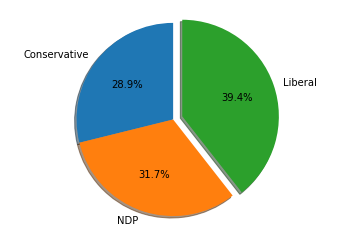

In [21]:
labels = 'Conservative','NDP','Liberal'
po_senti = elct_tweet.loc[elct_tweet['senti'] == 1, 'party']
prty_cnt = po_senti.apply(lambda x: pd.value_counts(str(x).split(" "))).sum(axis = 0)
print(prty_cnt[:3])
total_cnt = sum(prty_cnt) - prty_cnt.Others

fracs = [(prty_cnt.Conservative/total_cnt)*100,\
          (prty_cnt.NDP/total_cnt)*100,(prty_cnt.Liberal/total_cnt)*100,]

explode = (0, 0, 0.1)  # only "explode" the 2nd slice (i.e. 'Liberal')
# Make square figures and axes
fig2, ax2 = plt.subplots()
ax2.pie(fracs, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax2.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
print('Tweets with Positive Sentiment values Predicted for Each Party')
plt.show()